In [17]:
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import polars as pl
import cv2
from IPython.display import Image, display
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten,BatchNormalization
from tensorflow.keras.layers import Dense, MaxPooling2D,Conv2D
from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten,Input

#import face_recognition

In [2]:
data=pl.read_csv('labels.csv')

In [3]:
data

,pth,label,relFCs
i64,str,str,f64
0,"""anger/image0000006.jpg""","""surprise""",0.873142
1,"""anger/image0000060.jpg""","""anger""",0.852311
2,"""anger/image0000061.jpg""","""anger""",0.800957
3,"""anger/image0000066.jpg""","""disgust""",0.843079
4,"""anger/image0000106.jpg""","""anger""",0.849108
…,…,…,…
28170,"""surprise/image0034960.jpg""","""surprise""",0.825263
28171,"""surprise/image0034961.jpg""","""surprise""",0.738646
28172,"""surprise/image0034966.jpg""","""surprise""",0.774524


In [4]:
def image_show(i):
    row = data.row(i)
    pth = row[1]
    image_path = pth
    img = mpimg.imread(image_path)
    return img, row[2]

In [5]:
i=0
row = data.row(i)
pth = row[1]
image_path = pth
img = mpimg.imread(image_path)
# Check the shape of the image
height, width, channels = img.shape
print(f"Height - {height}", f", width - {height}",f", Color - {channels}")

#Color -3 means RGB, Color - 1 means Gray

Height - 96 , width - 96 , Color - 3


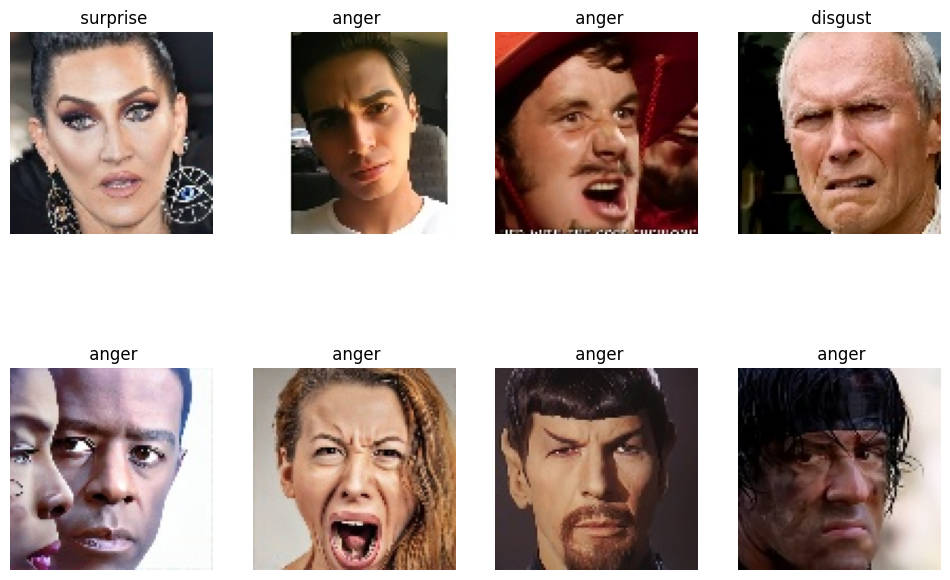

In [6]:
i=8
num_cols=int(i/2)
num_rows=int(i/num_cols)+i%2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i in range(0,i):
    row = i // num_cols
    col = i % num_cols
    img_path,title=image_show(i)
    axes[row, col].imshow(img_path)
    axes[row, col].set_title(f' {title}')
    axes[row, col].axis('off')

Text(0.5, 1.0, 'Grey Image')

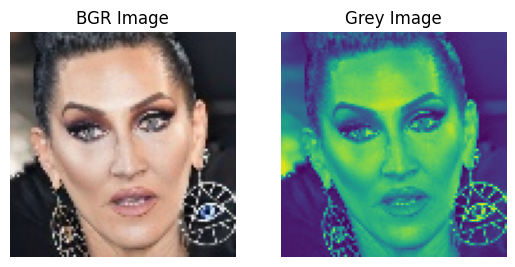

In [7]:
# Convert to grayscale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Normalize pixel values to the range [0, 1]
img_normalized = img_gray / 255.0

# Now, img_normalized contains pixel values in the range [0, 1] as grayscale

# Display the BGR image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title('BGR Image')

plt.subplot(1, 2, 2)
plt.imshow(img_normalized)
plt.axis('off')
plt.title('Grey Image')

In [8]:
# Extract features (image paths) and labels
X = data['pth'].to_numpy()
y = data['label'].to_numpy()

In [9]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img_gray, (96, 96))
    img_normalized = img_resized / 255.0
    return img_normalized


X_preprocessed=np.array([preprocess_image(image_path) for image_path in X])

# Labeling the data
le = LabelEncoder()
y_preprocessed = to_categorical(le.fit_transform(y))

In [10]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_preprocessed, test_size=0.2, random_state=42, stratify=y)

In [11]:
input_shape=X_preprocessed[0].shape

input_shape

(96, 96)

In [13]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras import models, layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
import platform
from keras.optimizers import Adam

# # create model structure
# model = Sequential()

# input_shape=(96, 96, 1)
# model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape= input_shape))
# model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))
# #Number of class
# num_class= len(np.unique(y))
# model.add(Dense(num_class, activation='softmax'))

# # Compile the model

# if 'M1' in platform.processor() or 'M2' in platform.processor():
#     optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
# else:
#     optimizer = Adam(learning_rate=0.001)
    
    
# model.compile(optimizer=Adam(learning_rate=0.001), 
#               loss='categorical_crossentropy', 
#               metrics=['accuracy'])

In [30]:
num_classes = 8  # Update this to match the number of classes in your dataset

model = Sequential()

# Input layer
model.add(Input(shape=(96, 96, 1)))

# CNN Architecture
model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', strides=(1, 1), kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', strides=(1, 1), kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='sigmoid'))  # Update this line

# Model compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Configure Model Checkpoint
checkpoint_path = 'affectnet/emotion_model_best.keras'
checkpointer = ModelCheckpoint(filepath=checkpoint_path, 
                               monitor='val_loss', 
                               verbose=1, 
                               save_best_only=True, 
                               mode='min')

# Add the callback to your callback list
callback_list = [checkpointer]

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 96, 96, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,568,648 (5.98 MB)

 Trainable params: 1,568,648 (5.98 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
num_epochs=20
batch_size=64
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 139s 493ms/step - accuracy: 0.1766 - loss: 2.1282 - val_accuracy: 0.2751 - val_loss: 1.9175
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 121s 427ms/step - accuracy: 0.3157 - loss: 1.8316 - val_accuracy: 0.3815 - val_loss: 1.7110
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 144s 511ms/step - accuracy: 0.3933 - loss: 1.6424 - val_accuracy: 0.4186 - val_loss: 1.6233
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 167s 594ms/step - accuracy: 0.4279 - loss: 1.5511 - val_accuracy: 0.4596 - val_loss: 1.5382
Epoch 5/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 169s 598ms/step - accuracy: 0.4448 - loss: 1.5026 - val_accuracy: 0.4791 - val_loss: 1.4924
Epoch 6/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 166s 588ms/step - accuracy: 0.4736 - loss: 1.4387 - val_accuracy: 0.5022 - val_loss: 1.4316
Epoch 7/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 136s 483ms/step - accuracy: 0.4883 - loss: 1.4067 - val_accuracy: 0.5016 - val_loss: 1.4174
Epoch 8/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 168s 595ms/step - accuracy: 0.5055 -

<Axes: >

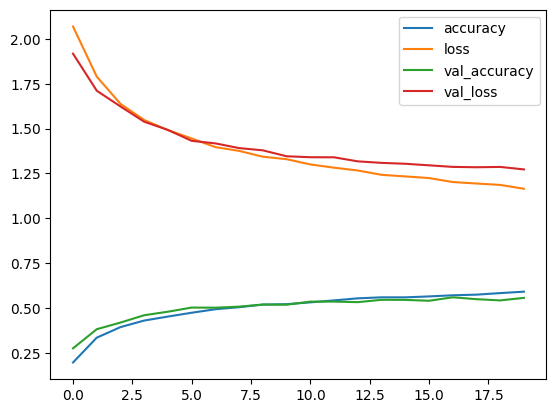

In [33]:
pd.DataFrame(history.history).plot()

In [41]:
label_mapping={0: 'anger',
 1: 'contempt',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprise'}

177/177 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step
      Label  Precision    Recall  F1-score       AUC
0     anger   0.532428  0.488920  0.509747  0.883110
1  contempt   0.620493  0.503852  0.556122  0.894528
2   disgust   0.460912  0.407781  0.432722  0.790078
3      fear   0.562327  0.333333  0.418557  0.886755
4     happy   0.821470  0.811995  0.816705  0.972475
5   neutral   0.426910  0.449301  0.437819  0.840927
6       sad   0.398844  0.460768  0.427576  0.803112
7  surprise   0.512509  0.732394  0.603033  0.868687
8   Overall   0.541987  0.523543  0.525285  0.867181


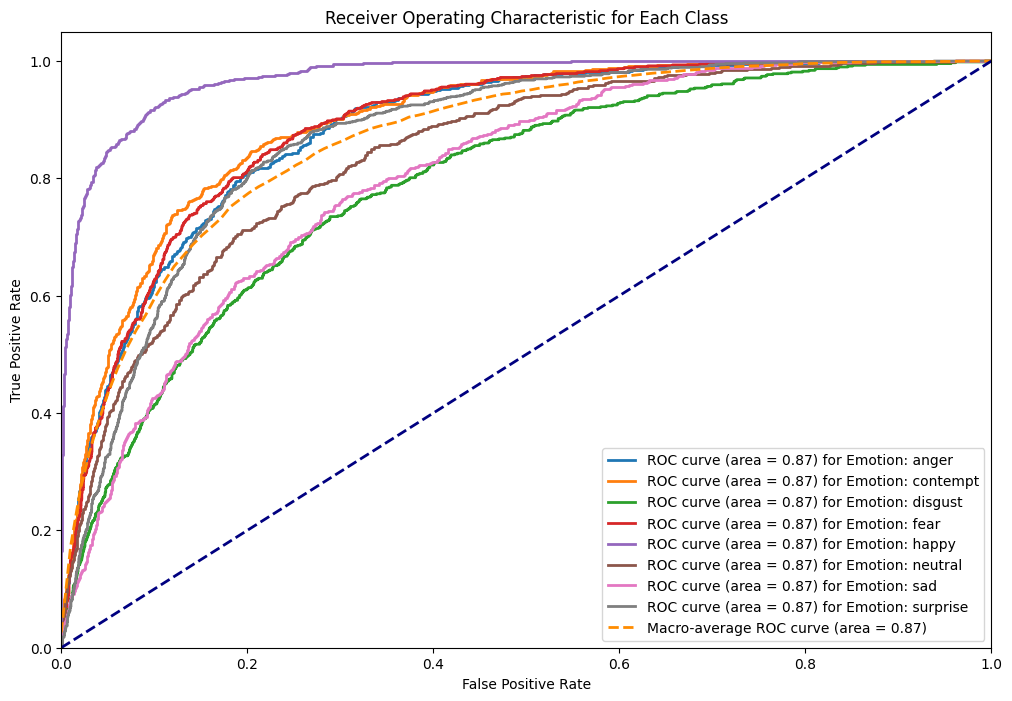

In [42]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc

y_pred_prob=model.predict(X_test)
# Convert probabilities to binary predictions
y_pred_labels = np.argmax(y_pred_prob, axis=1)

# Convert y_test to binary labels
y_true_labels = np.argmax(y_test, axis=1)

# List to store individual precision, recall, and F1-score values for each class
class_metrics = []

# List to store individual AUC values and ROC curves for each class
roc_curves = []


for i in range(8):
    # Convert predicted and true labels to binary labels
    y_pred_binary = (y_pred_labels == i)
    y_true_binary = (y_true_labels == i)
    
    # Calculate precision, recall, and F1-score
    precision = precision_score(y_true_binary, y_pred_binary)
    recall = recall_score(y_true_binary, y_pred_binary)
    f1 = f1_score(y_true_binary, y_pred_binary)
    
    # ROC curve calculation
    fpr, tpr, _ = roc_curve(y_true_binary, y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    roc_curves.append((fpr, tpr, label_mapping[i]))
    
    # Store metrics in a dictionary
    class_metrics.append({
        'Label': label_mapping[i],
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'AUC': roc_auc
    })


    
# Compute and plot macro-average ROC curve
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr, _ in roc_curves], axis=0)
macro_auc = auc(mean_fpr, mean_tpr)




# Calculate overall precision, recall, and F1-score
overall_precision = precision_score(y_true_labels, y_pred_labels, average='macro')
overall_recall = recall_score(y_true_labels, y_pred_labels, average='macro')
overall_f1 = f1_score(y_true_labels, y_pred_labels, average='macro')

class_metrics.append({
    'Label': 'Overall',
    'Precision': overall_precision,
    'Recall': overall_recall,
    'F1-score': overall_f1,
    'AUC': macro_auc
})


# Create a Pandas DataFrame from the list of metrics
metrics_df = pd.DataFrame(class_metrics)

# Optionally, print the metrics table
print(metrics_df)


# Plot ROC curve for each class
plt.figure(figsize=(12, 8))
lw = 2

    
for fpr, tpr, label in roc_curves:
    plt.plot(fpr, tpr, lw=lw, label='ROC curve (area = {:.2f}) for Emotion: {}'.format(roc_auc, label))

plt.plot(mean_fpr, mean_tpr, color='darkorange', linestyle='--', linewidth=2, label='Macro-average ROC curve (area = {:.2f})'.format(macro_auc))


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Each Class')
plt.legend(loc='lower right')
plt.show()


In [45]:
mismatch_index=[]
for i in range(0,len(y_true_labels)):
    if y_true_labels[i]!=y_pred_labels[i]:
        mismatch_index.append(i)

In [46]:
def pred_vs_actual_label(i):
    i=mismatch_index[i]
    img_array=X_test[i]
    img_array = (img_array * 255).astype(np.uint8)
    pred_label=label_mapping[y_pred_labels[i]]
    actual_label=label_mapping[y_true_labels[i]]
    return img_array,pred_label,actual_label

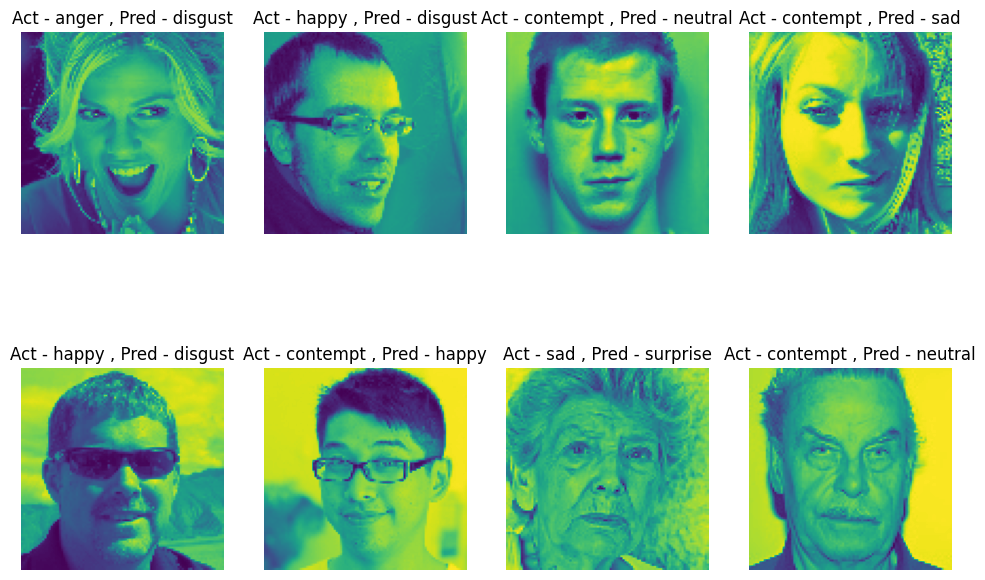

In [47]:
i=8
num_cols=int(i/2)
num_rows=int(i/num_cols)+i%2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i in range(0,i):
    row = i // num_cols
    col = i % num_cols
    img_array,pred_label,actual_label=pred_vs_actual_label(i)

    axes[row, col].imshow(img_array) 
    axes[row, col].set_title(f"Act - {actual_label}"+" , "+f"Pred - {pred_label}")
    axes[row, col].axis('off')